In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import os
from functools import partial
from matplotlib import pyplot as plt
import random
import albumentations as A
%matplotlib inline

In [2]:
tf.__version__

'2.3.1'

In [3]:
random.seed(47)

In [4]:
MEAN_RGB = tf.constant([127.0, 127.0, 127.0], shape=[1, 1, 3], dtype=tf.float32)
STDDEV_RGB = tf.constant([128.0, 128.0, 128.0], shape=[1, 1, 3], dtype=tf.float32)

In [5]:
train_files = ['../../data/coco_person_classification_tiny/train_class-00000-of-00005', 
               '../../data/coco_person_classification_tiny/train_class-00001-of-00005', 
               '../../data/coco_person_classification_tiny/train_class-00002-of-00005', 
               '../../data/coco_person_classification_tiny/train_class-00003-of-00005', 
               '../../data/coco_person_classification_tiny/train_class-00004-of-00005']
val_files = ['../../data/coco_person_classification_tiny/val_class-00000-of-00005', 
             '../../data/coco_person_classification_tiny/val_class-00001-of-00005', 
             '../../data/coco_person_classification_tiny/val_class-00002-of-00005', 
             '../../data/coco_person_classification_tiny/val_class-00003-of-00005', 
             '../../data/coco_person_classification_tiny/val_class-00004-of-00005']
has_bg = True

In [6]:
# Create a dictionary describing the features.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/class/id':
        tf.io.VarLenFeature(tf.int64),
    'image/class/text':
        tf.io.VarLenFeature(tf.string),
}

In [51]:
class TFClassificationDataGenerator(object):

    def __init__(self,
                 training_files,
                 validation_files,
                 num_classes,
                 train_aug = None,
                 val_aug = None,
                 include_bgclass=False,
                 train_size=None,
                 val_size=None,
                 repeatds=True,
                 img_size=None,
                 normalize_image=False):

        assert len(val_files) > 0, 'No validation files found'
        assert len(train_files) > 0, 'No training files found'
        assert train_size > 0, 'Please provide train ds size for ease of use'
        assert val_size > 0, 'Please provide validation ds size for ease of use'

        self.num_classes = num_classes
        self.include_bgclass = include_bgclass
        self.effective_ncls = self.num_classes + 1 if self.include_bgclass else self.num_classes
        self.repeatds = repeatds
        self.val_raw_ds = tf.data.TFRecordDataset(val_files, num_parallel_reads=3)
        self.train_raw_ds = tf.data.TFRecordDataset(train_files, num_parallel_reads=3)
        self.train_aug_pipeline = train_aug
        self.val_aug_pipeline = val_aug
        self.train_size = train_size
        self.val_size = val_size
        self.img_size = img_size
        self.normalize_image=normalize_image

    

    def _parse_train_image_function(self, example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        parsed_data = tf.io.parse_single_example(example_proto, image_feature_description)
        
        #image functions
        image = tf.image.decode_jpeg(parsed_data['image/encoded'], channels=3)
        
        if self.train_aug_pipeline != None:
            aug_img = tf.numpy_function(func=self._train_aug_fn, inp=[image], Tout=tf.uint8)
        else:
            aug_img = image
            
        if self.normalize_image:
            aug_img = tf.cast(aug_img/255.0, tf.float32)

        if self.img_size != None:
            aug_img = tf.image.resize(aug_img, size=[self.img_size, self.img_size])
            
        lbl = parsed_data['image/class/id'].values

        one_hot = tf.one_hot(lbl, depth=self.effective_ncls)
        one_hot_multi = tf.reduce_max(one_hot, axis=0)

        return [aug_img, one_hot_multi]

    
    def _parse_val_image_function(self, example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        parsed_data = tf.io.parse_single_example(example_proto, image_feature_description)
        
        #image functions
        image = tf.image.decode_jpeg(parsed_data['image/encoded'], channels=3)
        
        if self.val_aug_pipeline != None:
            aug_img = tf.numpy_function(func=self._val_aug_fn, inp=[image], Tout=tf.uint8)
        else:
            aug_img = image
            
        if self.normalize_image:
            aug_img = tf.cast(aug_img/255.0, tf.float32)

        if self.img_size != None:
            aug_img = tf.image.resize(aug_img, size=[self.img_size, self.img_size])

        lbl = parsed_data['image/class/id']

        one_hot = tf.one_hot(lbl, depth=self.effective_ncls)
        one_hot_multi = tf.reduce_max(one_hot, axis=0)

        return [aug_img, one_hot_multi]


    def _train_aug_fn(self, image):
        data = {"image":image}
        aug_data = self.train_aug_pipeline(**data)
        aug_img = aug_data["image"]

        return aug_img
    
    
    def train_generator(self, batchsize):
        if self.repeatds:
            tf_trainds = self.train_raw_ds.repeat()
        else:
            tf_trainds = self.train_raw_ds
        tf_trainds = tf_trainds.shuffle(buffer_size=1024)
        tf_trainds = tf_trainds.map(self._parse_train_image_function, num_parallel_calls=AUTOTUNE)

        tf_trainds = tf_trainds.prefetch(AUTOTUNE)
        dataset_itr = tf_trainds.batch(batchsize, drop_remainder=False)
        return dataset_itr
    
    
    def _val_aug_fn(self,image, img_size):
        data = {"image":image}
        aug_data = self.val_aug_pipeline(**data)
        aug_img = aug_data["image"]

        return aug_img

    def validation_generator(self, batchsize):
        if self.repeatds:
            tf_valds = self.val_raw_ds.repeat()
        else:
            tf_valds = self.val_raw_ds
        tf_valds = tf_valds.shuffle(buffer_size=1024)
        tf_valds = tf_valds.map(self._parse_val_image_function, num_parallel_calls=AUTOTUNE)
        tf_valds = tf_valds.prefetch(AUTOTUNE)
        dataset_itr = tf_valds.batch(batchsize, drop_remainder=False)
        return dataset_itr

In [52]:
train_transform = A.Compose([
        A.Rotate(limit=180),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=0, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

In [53]:
val_transform = A.Compose([
        A.Rotate(limit=180),
        A.Flip(),
        A.ToGray(0.2),
    ])

In [54]:
df_gen = TFClassificationDataGenerator(training_files=train_files,
                                       validation_files=val_files,
                                       num_classes=3,
                                       train_size=2000,
                                       val_size=2000,
                                       train_aug=train_transform,
                                       val_aug=val_transform
                                      )

In [55]:
train_gen = df_gen.train_generator(1)

In [56]:
def view_image(ds, num_samples=5):
    image = []
    label = []
    for _ in range(num_samples):
        i, l = next(iter(ds)) # extract 1 batch from the dataset
        image.append(i.numpy()[0])
        label.append(l.numpy()[0])
        print(l.numpy())

    fig = plt.figure(figsize=(22, 22))
    for i in range(num_samples):
        ax = fig.add_subplot(num_samples//5, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {str(label[i])}")

[[1. 0. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[1. 0. 0.]]
[[0. 1. 1.]]
[[0. 1. 1.]]
[[0. 1. 0.]]
[[0. 1. 1.]]
[[1. 0. 0.]]
[[1. 0. 0.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 1. 0.]]
[[1. 0. 0.]]
[[0. 1. 0.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


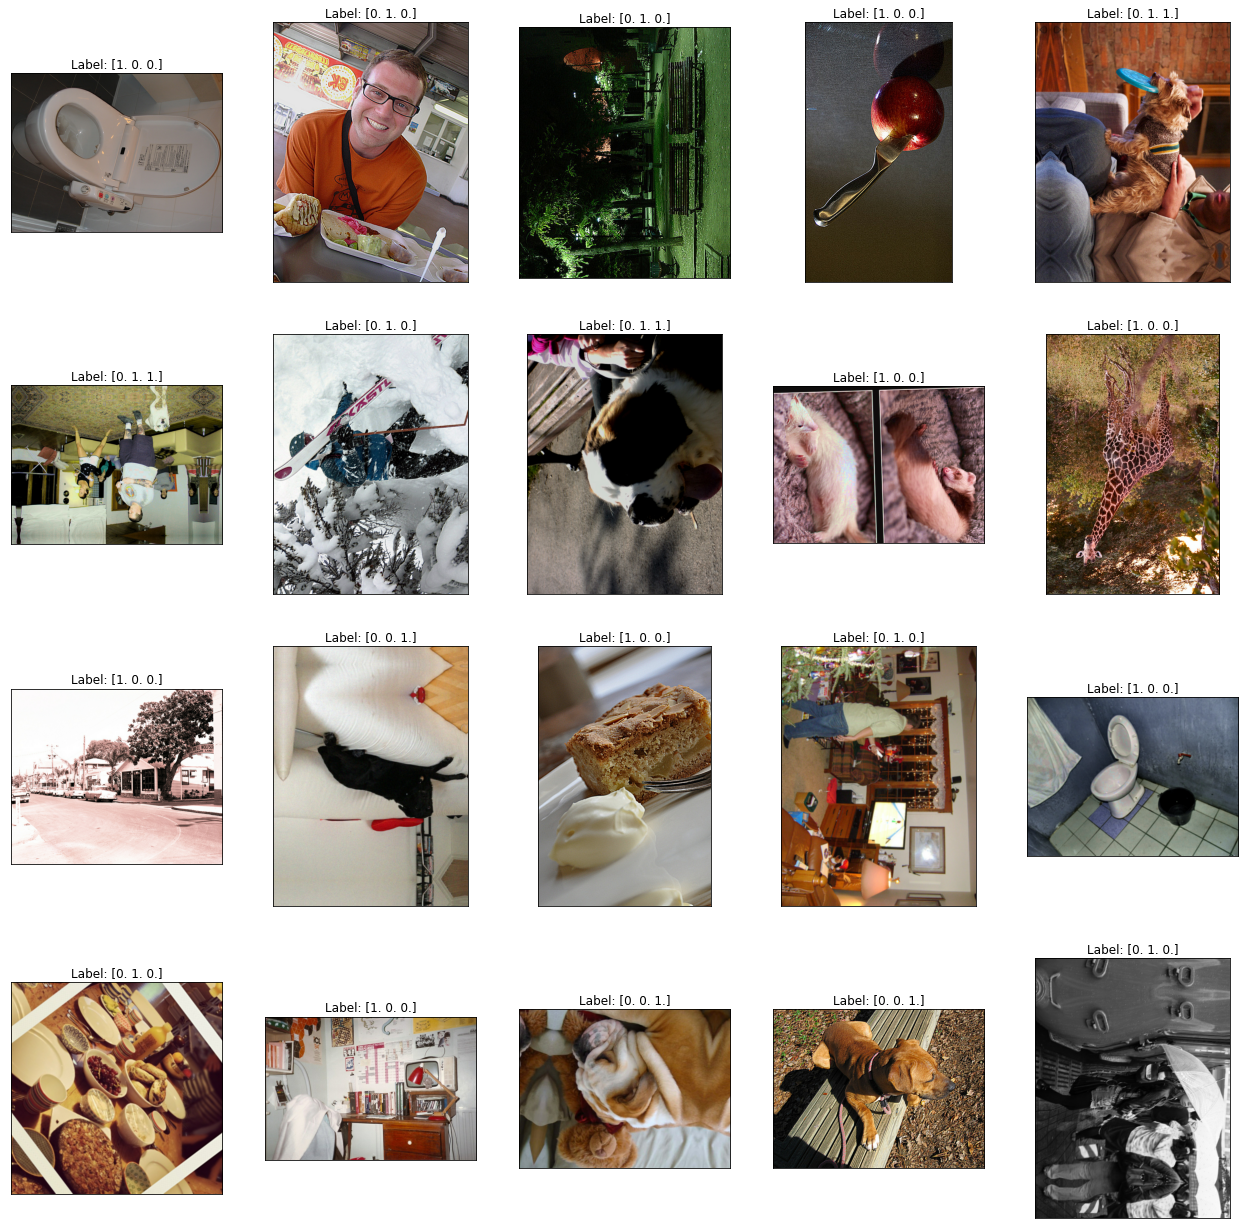

In [57]:
view_image(train_gen, num_samples=20)

### Write the Image

In [31]:
import cv2
import pandas as pd
import numpy as np

In [32]:
train_ds_trial = df_gen.val_raw_ds

In [33]:
gsc_basepath = 'gs://ml_sahil_v1/per_dog_bg/imgs/'
local_path = '../../data/coco_person_classification_tiny/imgs'
csv_path = '../../data/coco_person_classification_tiny/train_val_class.csv'

In [34]:
class_dict = {0: 'background', 1: 'person', 2: 'dog'}

In [20]:
csv_data = []

In [23]:
for i, data in enumerate(train_ds_trial):
    if i % 500 == 0:
        print(i)
    parsed_data = tf.io.parse_single_example(data, image_feature_description)
#     print(parsed_data.keys())
    image = tf.image.decode_jpeg(parsed_data['image/encoded'], channels=3).numpy()
#     print(image.shape)
    filename = str(i)+'_val'+'.jpg'
    cv2.imwrite(os.path.join(local_path, filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
#     plt.imshow(image)
    rec = {'image_path': gsc_basepath + filename}
    for ci, cid_t in enumerate(parsed_data['image/class/id'].values):
        cid = cid_t.numpy()
        cname = class_dict[cid]
        rec['label'+str(ci+1)] = cname
#     csv_data.append(rec)
    break
#     if i > 2000:
#         break

0
500
1000
1500
2000


In [24]:
len(csv_data)

6522

In [27]:
csv_pd = pd.DataFrame(csv_data)

In [33]:
csv_pd.fillna('', inplace=True)

In [40]:
csv_pd.to_csv(csv_path, index=False)

In [41]:
#change part of path if required
csv_pd['image_path'] = csv_pd['image_path'].str.replace('/ml_sahil/', '/ml_sahil_v1/')

### one hot encode Trial 

In [39]:
for i, data in enumerate(train_ds_trial):
    parsed_data = tf.io.parse_single_example(data, image_feature_description)
    class_ids = parsed_data['image/class/id'].values
    if class_ids.shape == 1:
        one_hot = tf.one_hot(class_ids, depth=3)
        one_hot_multi = tf.reduce_max(one_hot, axis=0)
        print(one_hot, one_hot_multi)
        break
#     if i > 2000:
#         break

tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


### Augmentation Trial

ValueError: num must be 1 <= num <= 20, not 21

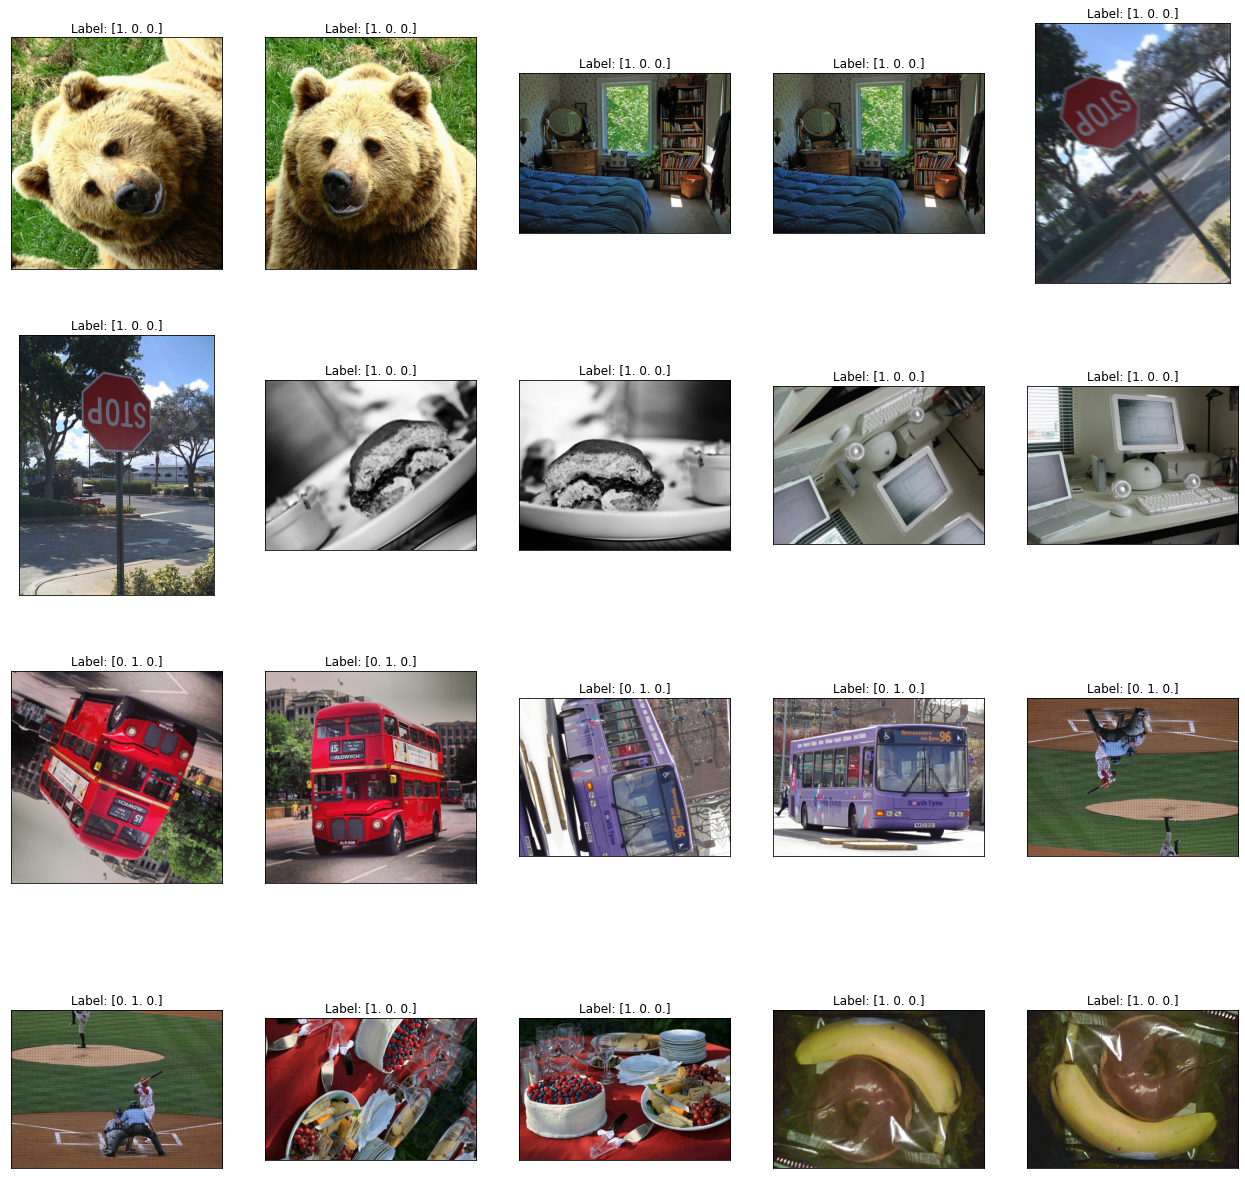

In [40]:
num_samples = 20
counter = 0
image_arr = []
label_arr = []

for i, data in enumerate(train_ds_trial):

    parsed_data = tf.io.parse_single_example(data, image_feature_description)
    # image
    image = tf.image.decode_jpeg(parsed_data['image/encoded'], channels=3).numpy()
    data = {"image":image}
    aug_data = val_transform(**data)
    aug_img = aug_data["image"]
    
    # class encoding
    class_ids = parsed_data['image/class/id'].values
    one_hot = tf.one_hot(class_ids, depth=3)
    one_hot_multi = tf.reduce_max(one_hot, axis=0)
#         print(one_hot, one_hot_multi)
        
    image_arr.append(aug_img)
    image_arr.append(image)
    label_arr.append(one_hot_multi.numpy())
    label_arr.append(one_hot_multi.numpy())
    
    counter +=1
    if counter == num_samples:
        break
    

fig = plt.figure(figsize=(22, 22))
for i in range(num_samples*2):
    ax = fig.add_subplot(num_samples//5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(image_arr[i])
    ax.set_title(f"Label: {str(label_arr[i])}")